# Employee Turnover Prediction Starter Workbook

This workbook was started by the data scientist who originally worked on this project. It is organized around the following steps:
1. Import and Clean data
2. Explore data
3. Model features
4. Model data
5. Evaluate models

In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
#import plotly go
import plotly.graph_objs as go

## 2. Model

In [3]:
#Read in the data files
train = pd.read_csv("./Hr Analytics/data/train.csv",sep=",")
validate = pd.read_csv("./Hr Analytics/data/validate.csv",sep=",")
test = pd.read_csv("./Hr Analytics/data/test.csv",sep=",")

In [4]:
#Examine the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5178 entries, 0 to 5177
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        5178 non-null   int64  
 1   Attrition                         5178 non-null   int64  
 2   Age                               5178 non-null   int64  
 3   DistanceFromHome                  5178 non-null   int64  
 4   MonthlyIncome                     5178 non-null   int64  
 5   NumCompaniesWorked                5178 non-null   float64
 6   PercentSalaryHike                 5178 non-null   int64  
 7   TotalWorkingYears                 5178 non-null   float64
 8   TrainingTimesLastYear             5178 non-null   int64  
 9   YearsAtCompany                    5178 non-null   int64  
 10  YearsSinceLastPromotion           5178 non-null   int64  
 11  YearsWithCurrManager              5178 non-null   int64  
 12  Perfor

In [5]:
#Let's view some of the sample data
pd.set_option("display.max_columns", None)
train.head()

Unnamed: 0  Attrition  Age  DistanceFromHome  MonthlyIncome  \
0           0          0   38                22          29790   
1           1          0   30                 2         104450   
2           2          0   37                 7          44400   
3           3          1   37                 2          56470   
4           4          0   39                21          30670   

   NumCompaniesWorked  PercentSalaryHike  TotalWorkingYears  \
0                 4.0                 12                9.0   
1                 3.0                 11               10.0   
2                 2.0                 11               18.0   
3                 6.0                 17                7.0   
4                 1.0                 20               21.0   

   TrainingTimesLastYear  YearsAtCompany  YearsSinceLastPromotion  \
0                      3               6                        0   
1                      3               7                        1   
2                      3               1                        0   
3                      2               0                        0   
4                      5              21                        1   

   YearsWithCurrManager  PerformanceRating  JobInvolvement  \
0                     5                  3               3   
1                     7                  3               3   
2                     1                  3               4   
3                     0                  1               2   
4                     6                  4               3   

   EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  \
0                      2.0              4.0              3.0   
1                      1.0              3.0              3.0   
2                      4.0              3.0              4.0   
3                      1.0              3.0              2.0   
4                      2.0              4.0              4.0   

   NumCompaniesWorked_Missing  TotalWorkngYears_Missing  \
0                           1                         1   
1                           1                         1   
2                           1                         1   
3                           1                         1   
4                           1                         1   

   EnvironmentSatisfaction_Missing  JobSatisfaction_Missing  \
0                                1                        1   
1                                1                        1   
2                                1                        1   
3                                1                        1   
4                                1                        1   

   WorkLifeBalance_Missing  Age_Bin  Gender_Male  JobRole_Human_Resources  \
0                        1      1.0            1                        0   
1                        1      0.0            1                        0   
2                        1      1.0            1                        0   
3                        1      1.0            1                        0   
4                        1      1.0            0                        0   

   JobRole_Laboratory_Technician  JobRole_Manager  \
0                              0                0   
1                              0                0   
2                              0                0   
3                              0                0   
4                              0                0   

   JobRole_Manufacturing_Director  JobRole_Research_Director  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   JobRole_Research_Scientist  JobRole_Sales_Executive  \
0                           0                        0   
1                           0        

In [6]:
#Drop an extraneous column and determine the shape of the train data frame.
train=train.drop(['Unnamed: 0'], axis=1)
test=test.drop(['Unnamed: 0'], axis=1)
validate=validate.drop(['Unnamed: 0'], axis=1)
train.shape

(5178, 68)

#### Design Note 1.1

The data were explored, cleaned, and prepared for analysis in the notebook 1_employee_turn_data_prep.ipynb. This notebook contains a start to the model building process. We wil explore a basic model and some discussion of performance metrics. There are several Python packages that can be used to create a logistic regression model, and two of the more popular is scikit-learn and statsmodel. Scikit-learn is a machine learning package, whereas statsmodel falls more within the statistical tradition. Statsmodel provides some useful statistical output (```p-values```, ```coeff```, ```intervals```). Scikit-learn provides good fit metrics (```precision```, ```recall```, ```confusion matrix```) and fits within a machine learning model. Given that we want to do both explanatory and predictive modeling, we will use statsmodel in this file to create our model, which offers some nice statistical output, but we also will leverage some of scikit-learn and its fit metrics. For this initial exploratory modeling, we will use statsmodels for the primary modeling and statistical evaluation, but we will also lean heavily on many of the advanced fit metrics that scikit-learn provides.

In [7]:
# First, we setup a baseline model using statsmodel. We can use the logit model in statsmodel and our training data set
# to create a basic model. Attrition is our y-variable. We'll include a few predictors that seem to have
# potential as predictors.
# For those familiar with the r-programming lanugage, the syntax of statsmodels should feel familiar.

log_reg = sm.logit("Attrition ~ Age_sd + MonthlyIncome_sd", data=train).fit()

Optimization terminated successfully.
         Current function value: 0.672905
         Iterations 4


#### Design Note 1.2: Statistical Evaluation of the Model

One advantage of statsmodel is that it offers robust statistical reporting on models. By printing the ```summary()``` of the log, we can view some key aspects of model performance.

```Pseudo R-squ.```: In conventional linear regression, one metric of quality is R2, which represents the proportion of the variance in the dependent variable that is explained by the model. An R2 of 40% suggests that 40% of the variation of the dependent variable is explained by the independent variables. Because logistic regression does not utilize ordinary-least squares for fitting a model, it is not calculated to minimize variance, so R2 as a goodness-of-fit metric does not translate. Instead, we must use a psuedo-R2. Psuedo-R2 looks like traditional R2 in that it also ranges from 0 to 1, but it does not have the same intuition as R2. Psuedo-R2 is a relative metric that can be used to compare models on the same set of data.

```coef```: The coef. column contains the coefficient for each variable in the model. This helps us in model interpretation. If this were linear regression, we know that a 1 unit change in the x-variable would produce a ```coef``` change in the y-variable. For example, if we are modeling home size (sq ft) vs. home price ($), the coef would tell us that a 1 sq ft increase in size will impact home price by ```coef``` dollars. The intuition works differently in logistic regression. Because the exponents are expressed in log-odds, we have to exponentiate them to interpret them. Doing so will tell us how the odds change give the coefficient.

```P>|z|```: This column shows which variables are statistically significant. Anything below 0.05 would traditionally be considered statistically significant. Statistical significance is not the end-all-be-all. It can help in manually building explanatory models, informing variable inclusion decisions. For machine learning, we may well include non-statistically significant variables to improve predictive utility. Better metrics to judge if it is worth including a variable in model are those that consider model complexity vs. performance, such as AIC and BIC.

```[0.025  0.975]```: These columns provide a confidence interval around the coefficients, so we can consider uncertainty in our analysis. 

In [8]:
#Now that we fit a baseline model, we can examine some of the output to understand the results.
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 5178
Model:                          Logit   Df Residuals:                     5175
Method:                           MLE   Df Model:                            2
Date:                Sat, 16 Dec 2023   Pseudo R-squ.:                 0.02920
Time:                        18:43:00   Log-Likelihood:                -3484.3
converged:                       True   LL-Null:                       -3589.1
Covariance Type:            nonrobust   LLR p-value:                 3.019e-46
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0534      0.029     -1.864      0.062      -0.110       0.003
Age_sd              -0.4076      0.030    -13.765      0.000      -0.466      -0.350
MonthlyIncome_sd    -0.1120 

In [9]:
# Another way to veiw the model coefficients
print(log_reg.params)

Intercept          -0.053419
Age_sd             -0.407567
MonthlyIncome_sd   -0.112032
dtype: float64


#### Design Note 1.3: Exponentiating coefficients

As mentioned previously, logisitic regression coefficients are expressed in log-odds. In order to interpret them as odds-ratios, we have exponentiate them. Mathematically, if we take the mathematical constant e and raise it to the power of our coefficient, we will convert our values from log-odds to odds (e^[ln(OR)]). Recall that odds ratio represents a ratio of probabilities: if there is an 80% chance of winning a soccer (football) match and a 20% of losing it, then the odds ratio of winning is 0.8/0.2 or 4:1 (four-to-one). If the odds of an event are even (0.5, 0.5), then the odds ratio is 0.5/0.5 = 1 (or 1:1). See the course logistic regression overview for more discussion on coefficient interpretation: ([Introduction to Logistic Regression](https://docs.google.com/document/d/1VM_JxZ64zoGGg6aAICJBPW_fnRtKIBHodubKo4eBAaI/edit?usp=sharing))


In [10]:
# Build a data frame with odds ratios and their confidence intervals.
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
# Exponentiate the data frame
odds_ratios = np.exp(odds_ratios)

# Print the results
print(odds_ratios)

                        OR  Lower CI  Upper CI
Intercept         0.947983  0.896196  1.002763
Age_sd            0.665267  0.627758  0.705017
MonthlyIncome_sd  0.894015  0.845210  0.945639


#### Design Note 1.4: Confusion Matrices

One of the standard classification quality tools is the confusion matrix. A confusion matrix can be used in multinomial situations, but in binary classification, the confusion matrix allows the data scientist to measure four classification scenarios from the model: true positive, true negative, false positive, and false negative. The definitions of the metrics are found below:

```true positive (TP)```: A true positive is when the model predicts a positive-state outcome for the dependent variable and the ground truth is also positive. For example, if we were predicting if someone has diabetes given their blood levels, a true positive result would be that our model predicts the person has diabetes and they actually do. (Note that 'positive' means we predict something will happen; it does not necessarily mean that the outcome is good).

```true negative (TN)```: A true negative is when the model predicts a negative-state outcome for the dependent variable and the ground truth is also negative. For example, if we were predicting if someon has diabetes given their blood levels, a true negative result would be that the model predicts the person does not have diabetes and they do not in reality. (Note that 'negative' means we predict something does not happen, and it does not necessary mean that the outcome is good).

A perfect model will categorize all events as either true positives or true negatives. This is highly unlikely in most modeling situations, so we must learn about classification error: false positives and false negatives. 

```false positive (FP)```: A false positive is when the model predicts a positive-state outcome for the dependent variable and the ground truth is actually negative. Using our diabetes example, a false positive occurs when the model says someone has diabetes but in reality they do not. A false positive is a category of classification error.

```false negative (FN)```: A false negative is when the model predicts a negative-state outcome for the dependent variable and the ground truth is actually positive. Using our diabetes example, a false negative occurs when the model says someone does not have diabetes but in reality they do. A false negative is a category of classification error. 


```confusion matrix```: A confusion matrix consists of two axes that define four squares. Each square provides the raw count for a specific classification metric (TP, TN, FP, FN).The key to identifying which square is associated with which classification metric is knowing if the actual (ground truth) results are the rows or the columns.

For ```statsmodels```, we use a method called pred_table() to generate a confusion matrix (though you can also use sklearn's confusion matrix tools on non-sklearn models). According to the statsmodel documentation, "pred_table[i,j] refers to the number of times “i” was observed and the model predicted “j”. Correct predictions are along the diagonal." So the confusion matrix in statsmodels, the rows represent the actual (observed) classification and the columns represent the predicted. The diagonal from upper left to lower right are the true positives and true negatives. 


In [11]:
# Create a confusion matrix for our initial model on the training data set
log_reg.pred_table()

array([[1402., 1187.],
       [1000., 1589.]])

While ```statsmodels``` can provide a basic confusion matrix, ```scikit-learn``` offers much more in the way of classification metrics. Also, the confusion matrix above using our training data. Of course, if we were to evaluate modeling just on training data, we might easily find our way into overfitting. Below provides the necessary code snippets to (1) generate predictions on our test data set (how effective is our training model at predicting values that are out-of-sample?) and (2) create a basic confusion matrix as well as a more graphical representation.

In [12]:
# Building a confusion matrix on the test dataset

y_pred = log_reg.predict(test)

# Y-pred are the probabilities that each row (employee) in the test set will attrite. 
# To produce a confusion matrix work we need to change that those probabilities to binary (0,1) values. 
# This can be done by rounding the y_pred values
prediction = list(map(round, y_pred))
 

Before we populate the confusion matrix, a helpful exercise is to examine the probabilities we have produce for our test data set. In this context, these values represent the probability that individuals in the test data set will attrite.

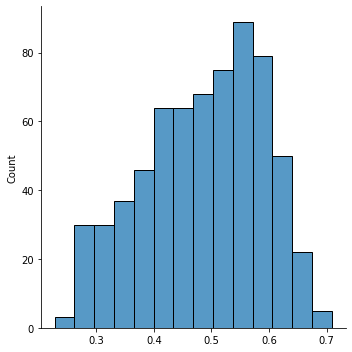

In [13]:
sns.displot(y_pred, kde=False, rug=False)

In [14]:
# Now that we have done the legwork, we can produce the desired confusion matrices.

# Create a sklearn confusion matrix
cm = confusion_matrix(test['Attrition'], prediction)
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], prediction))

Confusion Matrix : 
 [[310 238]
 [ 26  88]]
Test accuracy =  0.6012084592145015


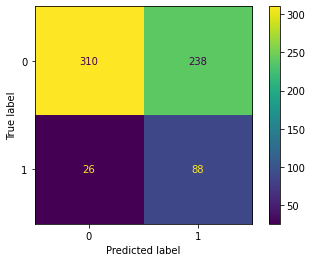

In [15]:
# Should we want a slightly more graphical display, sklearn also offers ConfusionMatrixDisplay()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Design Note 1.5: Fit metrics

As mentioned previously, the popular machine learning package ```scikit-learn``` can model several forms of regression, including logistical regression. Generally, its reporting on the statistical properities of models is not as robust as ```statsmodels```, but its fit metrics are superior. Specifically, ```scikit-learn``` provides built-in reporting for several key classification algorithms including precision, recall, F1, and AUC. We will use this metrics to better understand the complexities of our model performance. Below are some basic definitions for some of the fit metrics. For a more detailed discussion, refer to the course logistic regression guide: ([Introduction to Logistic Regression](https://docs.google.com/document/d/1VM_JxZ64zoGGg6aAICJBPW_fnRtKIBHodubKo4eBAaI/edit?usp=sharing))

Recall: A measure of a classifier's completeness <br>
How many relevant items are selected? <br>
Recall: TP / Real Positive = TP / (TP + FN) <br>
A model that produces no false negatives has a recall of 1.0.

Precision: A measure of a classifier's exactness.<br>
How many selected items are relevant?<br>
Precision: TP / Predicted Positive = TP / (TP + FP)<br>
A model that produces no false positives has a precision of 1.0.

F1-score:  the harmonic mean of precision and recall.

Sklearn provides a helpful classification report to provide a view into precision, recall, and f1-score. It provides these values for the overall model and disaggreagted by response variable outcome (0,1).

In [16]:
# Classification_report() has two required fields: the ground truth (y) and the binary predicted values (pred)

print(classification_report(test['Attrition'],prediction))

              precision    recall  f1-score   support

           0       0.92      0.57      0.70       548
           1       0.27      0.77      0.40       114

    accuracy                           0.60       662
   macro avg       0.60      0.67      0.55       662
weighted avg       0.81      0.60      0.65       662



#### Design Note 1.6: Graphic representations of fit

A final way we will explore the quality of our classification model (in this preliminary exploration) is examining a ROC curve (receiver operating characteristic curve). The name is a bit opaque, but in essence, the ROC curve plots the True Positive Rate (TPR --- also called recall) against the False Positive Rate (FPR --- defined as FP/(FP + TN)). When we plot this curve, we can consider the trade-off in false positive vs. true positive rate given a decision threshold. It also plots a curve (as its name implies) which gives a visual representation of model performance. Lastly, we can take the integral of the ROC curve we plot to calculate the area under the curve (AUC). A model that has no correct predictions would have the worst possible AUC score (0.0); a model with very prediction correct (only true positives and true negatives) would have the maxmimum AUC score (1.0).

In [17]:
# First we use sklearn's roc_auc_score() function to find the area under the curve for our initial model. 
# Having calculated this value, we can then plot in on a graph along with our ROC curve.

auc=roc_auc_score(test['Attrition'],y_pred )
print(auc)

0.6971923421692918


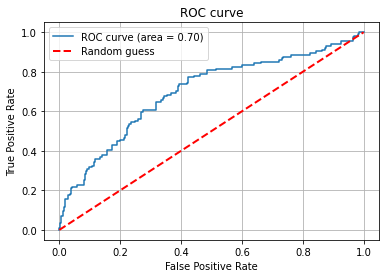

In [18]:
# Use Scikit-learn's ROC Curve Utility to plot ROC curve. For reference, we also include a 'line of determination (y=x)',
# which represents no lift from the model (just random guessing, the worst kind of model performance).
# Our goal is to produce a model that separates from the line of determination and captures as much of the area above the line
# as possible. 

og_fpr, og_tpr, og_thresholds = roc_curve(test['Attrition'],  y_pred)

# Create ROC curve
plt.plot(og_fpr, og_tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [19]:
import plotly.express as px
import plotly.graph_objects as go

In [20]:
train.head()

Attrition  Age  DistanceFromHome  MonthlyIncome  NumCompaniesWorked  \
0          0   38                22          29790                 4.0   
1          0   30                 2         104450                 3.0   
2          0   37                 7          44400                 2.0   
3          1   37                 2          56470                 6.0   
4          0   39                21          30670                 1.0   

   PercentSalaryHike  TotalWorkingYears  TrainingTimesLastYear  \
0                 12                9.0                      3   
1                 11               10.0                      3   
2                 11               18.0                      3   
3                 17                7.0                      2   
4                 20               21.0                      5   

   YearsAtCompany  YearsSinceLastPromotion  YearsWithCurrManager  \
0               6                        0                     5   
1               7                        1                     7   
2               1                        0                     1   
3               0                        0                     0   
4              21                        1                     6   

   PerformanceRating  JobInvolvement  EnvironmentSatisfaction  \
0                  3               3                      2.0   
1                  3               3                      1.0   
2                  3               4                      4.0   
3                  1               2                      1.0   
4                  4               3                      2.0   

   JobSatisfaction  WorkLifeBalance  NumCompaniesWorked_Missing  \
0              4.0              3.0                           1   
1              3.0              3.0                           1   
2              3.0              4.0                           1   
3              3.0              2.0                           1   
4              4.0              4.0                           1   

   TotalWorkngYears_Missing  EnvironmentSatisfaction_Missing  \
0                         1                                1   
1                         1                                1   
2                         1                                1   
3                         1                                1   
4                         1                                1   

   JobSatisfaction_Missing  WorkLifeBalance_Missing  Age_Bin  Gender_Male  \
0                        1                        1      1.0            1   
1                        1                        1      0.0            1   
2                        1                        1      1.0            1   
3                        1                        1      1.0            1   
4                        1                        1      1.0            0   

   JobRole_Human_Resources  JobRole_Laboratory_Technician  JobRole_Manager  \
0                        0                              0                0   
1                        0                              0                0   
2                        0                              0                0   
3                        0                              0                0   
4                        0                              0                0   

   JobRole_Manufacturing_Director  JobRole_Research_Director  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   JobRole_Research_Scientist  JobRole_Sales_Executive  \
0                           0                        0   
1                           0                        0   
2                           0                        1   
3                       

In [21]:
def normalize(df, norm):
    df_norm = norm.transform(df)
    df_norm = pd.DataFrame(df_norm, columns=df.columns)
    df_norm["Attrition"] = df_norm["Attrition"].replace(-1,0)
    return df_norm

In [22]:
normalizer = preprocessing.StandardScaler().fit(train)
train_norm_df = normalize(train, normalizer)
test_norm_df = normalize(test, normalizer)


In [23]:
normalizer

StandardScaler()

In [24]:
test_norm_df

Attrition       Age  DistanceFromHome  MonthlyIncome  NumCompaniesWorked  \
0          0.0 -0.739591         -0.632018       0.879391            0.095480   
1          0.0  2.676352         -0.908757      -0.812736           -1.131264   
2          0.0  0.582709         -0.770387      -0.817213            0.095480   
3          0.0 -0.519208          1.443531      -0.529223           -0.722350   
4          0.0 -0.188633          1.720271       2.698992            1.322224   
..         ...       ...               ...            ...                 ...   
657        0.0  2.235585          1.028421      -0.225032            2.548968   
658        1.0 -0.739591         -0.355278       0.971479            1.322224   
659        0.0 -0.409016          0.474942       0.117742            2.548968   
660        0.0  0.252134         -1.047127       2.393096            0.504395   
661        0.0  2.345777         -0.908757      -0.930192            0.095480   

     PercentSalaryHike  TotalWorkingYears  TrainingTimesLastYear  \
0            -0.093154           0.117275               1.095270   
1             0.329035           0.253046               0.264187   
2            -0.093154          -0.561579               0.264187   
3            -0.093154          -0.018496               0.264187   
4             0.117941           0.388817               0.264187   
..                 ...                ...                    ...   
657           0.329035           3.511548              -1.397978   
658           0.329035           0.117275              -0.566895   
659           1.595601          -0.018496               2.757435   
660           0.751224           0.253046              -2.229060   
661           0.329035           0.253046               1.926352   

     YearsAtCompany  YearsSinceLastPromotion  YearsWithCurrManager  \
0         -0.524698                -0.321000             -0.439525   
1          0.862441                -0.321000              1.646779   
2         -0.871482                -0.655435             -1.035612   
3          0.689049                -0.321000              1.348736   
4          0.862441                 1.016737              1.646779   
..              ...                      ...                   ...   
657        0.168872                 1.685606              1.050692   
658        0.515656                -0.655435              1.050692   
659        0.342264                 1.685606              1.050692   
660        0.342264                -0.655435              1.050692   
661       -0.177913                -0.321000              0.156562   

     PerformanceRating  JobInvolvement  EnvironmentSatisfaction  \
0             0.568447        1.487210                 1.284598   
1             0.568447        0.425766                 1.284598   
2             0.568447        1.487210                 1.284598   
3             0.568447        0.425766                 0.314836   
4             0.568447        0.425766                 1.284598   
..                 ...             ...                      ...   
657           0.568447        0.425766                 1.284598   
658          -1.701832       -0.635677                -1.624687   
659           1.703586        0.425766                 1.284598   
660           0.568447        0.425766                 1.284598   
661           0.568447        0.425766                 1.284598   

     JobSatisfaction  WorkLifeBalance  NumCompaniesWorked_Missing  \
0           0.191737         1.436778                    0.073735   
1           1.235649         1.436778                    0.073735   
2          -1.896086         0.415216                    0.073735   
3           0.191737        -0.606346                    0.073735   
4           0.191737         1.436778                    0.073735   
..               ...              ...                         ...   
657         0.191737        -1.627908                    0.073735   
658         0.191

In [25]:
corr = train_norm_df.corr()
corr = corr["Attrition"].sort_values()
corr.values
corr.keys()

Index(['PerformanceRating', 'WorkLifeBalance_sd', 'WorkLifeBalance',
       'PerformanceRating_sd', 'JobInvolvement', 'PercentSalaryHike',
       'PercentSalaryHike_sd', 'JobInvolvement_sd', 'JobSatisfaction_sd',
       'JobSatisfaction', 'EnvironmentSatisfaction_sd',
       'EnvironmentSatisfaction', 'YearsWithCurrManager',
       'MaritalStatus_Married', 'YearsWithCurrManager_sd',
       'TotalWorkingYears_sd', 'TotalWorkingYears', 'YearsAtCompany', 'Age',
       'YearsAtCompany_sd', 'BusinessTravel_Travel_Rarely', 'Education_3',
       'Age_sd', 'Age_Bin', 'Department_Research_Development',
       'Department_Sales', 'EducationField_Medical',
       'EducationField_Technical_Degree', 'StockOptionLevel_1',
       'JobSatisfaction_Missing', 'WorkLifeBalance_Missing',
       'JobRole_Manufacturing_Director', 'TrainingTimesLastYear',
       'JobRole_Research_Scientist', 'Gender_Male', 'JobLevel_2',
       'Education_4', 'JobLevel_3', 'StockOptionLevel_2', 'JobRole_Manager',
       'JobR

In [26]:
fig = go.Figure()
fig.add_trace(go.Bar(x=corr.keys(), y  = corr.values))
fig.show()

In [27]:
corr = corr[corr.values < -.2]

In [28]:
corr

PerformanceRating            -0.704804
WorkLifeBalance_sd           -0.644873
WorkLifeBalance              -0.644873
PerformanceRating_sd         -0.613979
JobInvolvement               -0.606569
PercentSalaryHike            -0.585463
PercentSalaryHike_sd         -0.558714
JobInvolvement_sd            -0.500171
JobSatisfaction_sd           -0.406721
JobSatisfaction              -0.406721
EnvironmentSatisfaction_sd   -0.369916
EnvironmentSatisfaction      -0.369916
YearsWithCurrManager         -0.270069
MaritalStatus_Married        -0.261727
YearsWithCurrManager_sd      -0.236078
TotalWorkingYears_sd         -0.231828
TotalWorkingYears            -0.231828
YearsAtCompany               -0.220775
Age                          -0.206721
Name: Attrition, dtype: float64

<AxesSubplot:>

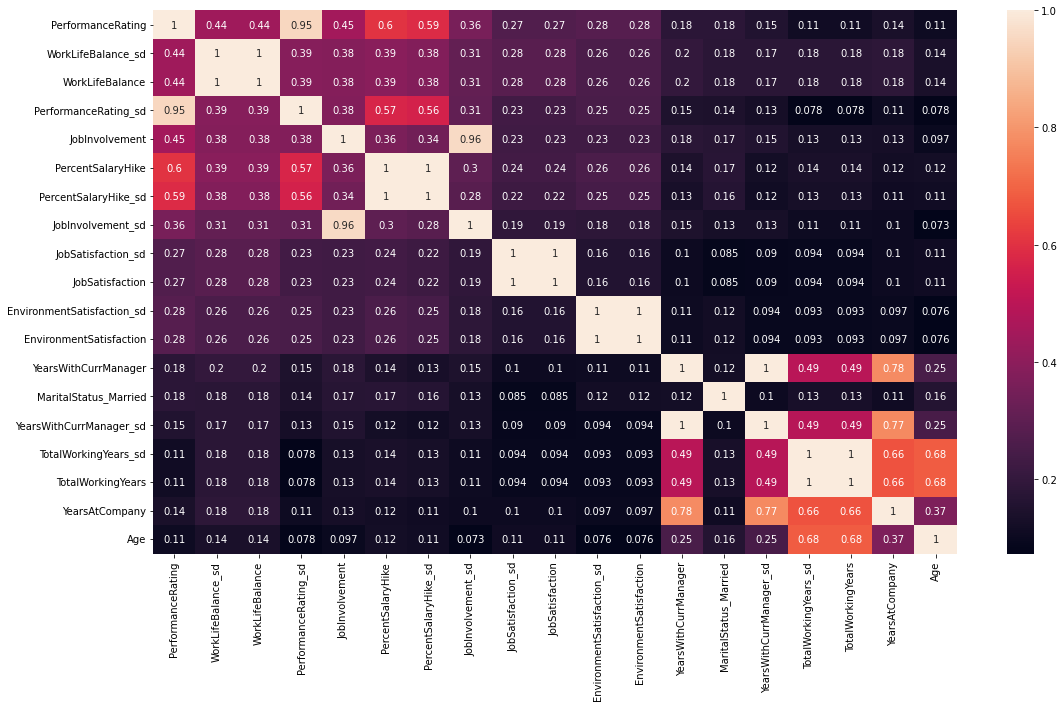

In [29]:
colinearity = train_norm_df[corr.keys()]
#Seaborn colin
colinearity = colinearity.corr()
plt.figure(figsize=(18,10))
sns.heatmap(colinearity, annot = True)


In [30]:
colinearity["DistanceFromHome"]["Age"]

KeyError: 'DistanceFromHome'

In [ ]:
colinearity["EnvironmentSatisfaction"]

PerformanceRating             0.272225
WorkLifeBalance_sd            0.245222
WorkLifeBalance               0.245222
JobInvolvement                0.246062
PerformanceRating_sd          0.248537
PercentSalaryHike             0.268574
PercentSalaryHike_sd          0.259444
JobInvolvement_sd             0.205059
JobSatisfaction_sd            0.161266
JobSatisfaction               0.161266
EnvironmentSatisfaction       1.000000
EnvironmentSatisfaction_sd    1.000000
MaritalStatus_Married         0.118332
YearsWithCurrManager          0.118153
TotalWorkingYears             0.109219
TotalWorkingYears_sd          0.109219
Age                           0.085850
YearsWithCurrManager_sd       0.105451
Age_sd                        0.080653
YearsAtCompany                0.104119
Age_Bin                       0.064732
Name: EnvironmentSatisfaction, dtype: float64

In [ ]:
print(train_norm_df.corr()["Age"]["MonthlyIncome"])
print(train_norm_df.corr()["Age"]["PerformanceRating"])
print(train_norm_df.corr()["Age"]["WorkLifeBalance"])

-0.03558800149550038
0.15202169535160334
0.1585000551889032


In [ ]:
print(train_norm_df.corr()["PerformanceRating"]["WorkLifeBalance"])
print(train_norm_df.corr()["JobInvolvement"]["WorkLifeBalance"])

print(train_norm_df.corr()["PercentSalaryHike"]["WorkLifeBalance"])
print(train_norm_df.corr()["JobInvolvement"]["PercentSalaryHike"])

0.437452387998546
0.3875399919489796
0.3843454048482024
0.37206901054695074


In [ ]:
train_norm_df["PerformanceRating"]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train["MonthlyIncome"], name="Performance Rating"))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train_norm_df["MonthlyIncome"], name="Performance Rating"))
fig.show()

KeyError: 'MonthlyIncome'

In [ ]:
def normalize(df, norm):
    df_norm = norm.transform(df)
    df_norm = pd.DataFrame(df_norm, columns=df.columns)
    df_norm["Attrition"] = df_norm["Attrition"].replace(-1,0)
    return df_norm

In [ ]:
train_final = train[["Attrition", "Age", "PerformanceRating","EnvironmentSatisfaction","DistanceFromHome"]]
test_final = test[["Attrition", "Age", "PerformanceRating","EnvironmentSatisfaction","DistanceFromHome"]]
normalizer = preprocessing.StandardScaler().fit(train_final)
train_norm_df = normalize(train_final, normalizer)
test_norm_df = normalize(test_final, normalizer)


In [31]:
train = pd.read_csv("./Hr Analytics/data/train.csv",sep=",")
validate = pd.read_csv("./Hr Analytics/data/validate.csv",sep=",")
test = pd.read_csv("./Hr Analytics/data/test.csv",sep=",")

In [32]:
log_reg = sm.logit("Attrition ~ PercentSalaryHike + EnvironmentSatisfaction  + TrainingTimesLastYear +WorkLifeBalance + JobSatisfaction +DistanceFromHome", data=train).fit() 
#log_reg = sm.logit("Attrition ~ PercentSalaryHike + WorkLifeBalance + JobInvolvement + EnvironmentSatisfaction+DistanceFromHome", data=train).fit() 
#log_reg = sm.logit("Attrition ~ PercentSalaryHike + WorkLifeBalance + JobInvolvement + EnvironmentSatisfaction+DistanceFromHome", data=train).fit() # 0.8545992901543228
#log_reg = sm.logit("Attrition ~ Age + PerformanceRating + EnvironmentSatisfaction", data=train_norm_df).fit() # 0.8545992901543228
print(log_reg.summary())

# Build a data frame with odds ratios and their confidence intervals.
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
# Exponentiate the data frame
odds_ratios = np.exp(odds_ratios)

# Print the results
print(np.round(odds_ratios,2))



Optimization terminated successfully.
         Current function value: 0.262897
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 5178
Model:                          Logit   Df Residuals:                     5171
Method:                           MLE   Df Model:                            6
Date:                Sat, 16 Dec 2023   Pseudo R-squ.:                  0.6207
Time:                        18:43:06   Log-Likelihood:                -1361.3
converged:                       True   LL-Null:                       -3589.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  14.3851      0.429     33.508      0.000      13.544   

In [33]:
base_line = np.round(odds_ratios/(1+odds_ratios),2)
print(base_line)

                           OR  Lower CI  Upper CI
Intercept                1.00      1.00      1.00
PercentSalaryHike        0.41      0.40      0.41
EnvironmentSatisfaction  0.34      0.31      0.36
TrainingTimesLastYear    0.42      0.40      0.44
WorkLifeBalance          0.14      0.12      0.15
JobSatisfaction          0.28      0.26      0.31
DistanceFromHome         0.51      0.51      0.52


In [34]:
#Merge train test and validate
df = pd.concat([train,test, validate])

In [35]:
def get_diff(df, log_reg, basline, indicator, value):
    df_mean = df.mean()
    df_mean[indicator] = df_mean[indicator]+value
    y_pred = log_reg.predict(df_mean)
    odds = np.exp(y_pred)
    new_value = odds/(1+odds)
    new_value = (basline - new_value)
   
    employees_stay = 3965*new_value
    print(f"{indicator} Employees that will stay {np.round(employees_stay[0])} new probability {new_value[0]*100} \
          Savings: {np.round(df.MonthlyIncome.mean()*np.round(employees_stay[0])*.66,2)} ")

In [36]:
7500 * 3965

29737500

In [37]:
df_mean = df.mean()
y_pred = log_reg.predict(df_mean)
odds = np.exp(y_pred)
basline = odds/(1+odds)
basline

0    0.598129
dtype: float64

In [38]:
salary_hike = 7500/df["MonthlyIncome"].mean()*100
get_diff(df, log_reg, basline, "PercentSalaryHike", salary_hike)
get_diff(df, log_reg, basline, "EnvironmentSatisfaction", .75)
get_diff(df, log_reg, basline, "TrainingTimesLastYear", .5)
get_diff(df, log_reg, basline, "WorkLifeBalance", .3)
get_diff(df, log_reg, basline, "JobSatisfaction", .5)

PercentSalaryHike Employees that will stay 382.0 new probability 9.632337593470563           Savings: 16108983.28 
EnvironmentSatisfaction Employees that will stay 110.0 new probability 2.7774302954597596           Savings: 4638712.46 
TrainingTimesLastYear Employees that will stay 34.0 new probability 0.8688392281061441           Savings: 1433783.85 
WorkLifeBalance Employees that will stay 118.0 new probability 2.967705005309562           Savings: 4976073.37 
JobSatisfaction Employees that will stay 100.0 new probability 2.516099408509842           Savings: 4217011.33 


In [39]:
df["MonthlyIncome"].mean()

63894.11105983695

In [40]:
df["TrainingTimesLastYear"].max()

6

In [41]:
df["MonthlyIncome"].min()

10090

In [42]:
df[df["MonthlyIncome"] < 11000]

Unnamed: 0  Attrition  Age  DistanceFromHome  MonthlyIncome  \
324          324          1   58                 1          10090   
1195        1195          0   36                 1          10510   
1290        1290          0   42                 2          10910   
1324        1324          0   42                 2          10910   
1477        1477          1   58                 1          10090   
1756        1756          0   24                 5          10520   
2340        2340          0   31                19          10810   
2469        2469          0   24                 5          10520   
2471        2471          0   36                 1          10510   
2588        2588          1   58                 1          10090   
2875        2875          0   31                19          10810   
2915        2915          0   36                 1          10510   
3130        3130          1   58                 1          10090   
3585        3585          1   44                 2          10664   
3597        3597          1   58                 1          10090   
3845        3845          1   58                 1          10090   
3885        3885          1   44                 2          10675   
4102        4102          1   58                 1          10090   
4198        4198          1   58                 1          10090   
4374        4374          1   58                 1          10090   
4388        4388          1   41                 2          10812   
4394        4394          1   48                 2          10501   
4596        4596          1   38                 3          10920   
4625        4625          1   58                 1          10090   
5079        5079          1   41                 2          10783   
252         2545          0   42                 2          10910   
33          2034          0   24                 5          10520   
569           55          0   31                19          10810   

      NumCompaniesWorked  PercentSalaryHike  TotalWorkingYears  \
324             7.000000                 13          31.000000   
1195            2.000000                 14          15.000000   
1290            2.000000                 22          16.000000   
1324            2.000000                 22          16.000000   
1477            7.000000                 10          31.000000   
1756            1.000000                 13           5.000000   
2340            4.000000                 11          13.000000   
2469            1.000000                 13           5.000000   
2471            2.000000                 14          15.000000   
2588            7.000000                  7          31.000000   
2875            4.000000                 11          13.000000   
2915            2.000000                 14          15.000000   
3130            7.000000                 12          31.000000   
3585            7.957109                 12          17.600479   
3597            7.000000                  9          31.000000   
3845            7.000000                  7          31.000000   
3885            7.975256                 14          17.346421   
4102            7.000000                 11          31.000000   
4198            7.000000                  7          31.000000   
4374            7.000000                  9          31.000000   
4388            8.204775                 10          14.133147   
4394            7.686488                  8          21.389170   
4596            8.384147                 10          11.621938   
4625            7.000000                 12          31.000000   
5079            8.155782                 11          14.819049   
252             2.000000                 22          16.000000   
33              1.000000                 13           5.000000   
569             4.000000                 11          13.000000   

      TrainingTimesLastYear  YearsAtCompany  YearsSinceLastPromotion  \
324              

In [43]:
salary_hike

11.738170976314603

In [44]:
df_mean = df.mean()
df_mean["EnvironmentSatisfaction"] = df_mean["EnvironmentSatisfaction"]+.75
y_pred = log_reg.predict(df_mean)
odds = np.exp(y_pred)
new_value = odds/(1+odds)
new_value = (basline - new_value)
print(new_value)
employees_stay = 3965*new_value
employees_stay

0    0.027774
dtype: float64


0    110.125111
dtype: float64

In [45]:
df_mean = df.mean()
df_mean["TrainingTimesLastYear"] = df_mean["TrainingTimesLastYear"]+.5
y_pred = log_reg.predict(df_mean)
odds = np.exp(y_pred)
new_value = odds/(1+odds)
new_value = (basline - new_value)
print(new_value)
employees_stay = 3965*new_value
employees_stay

0    0.008688
dtype: float64


0    34.449475
dtype: float64

In [46]:
df_mean = df.mean()
df_mean["WorkLifeBalance"] = df_mean["WorkLifeBalance"]+.3
y_pred = log_reg.predict(df_mean)
odds = np.exp(y_pred)
new_value = odds/(1+odds)
new_value = (basline - new_value)
print(new_value)
employees_stay = 3965*new_value
employees_stay

0    0.029677
dtype: float64


0    117.669503
dtype: float64

In [47]:
df_mean = df.mean()
df_mean["PercentSalaryHike"] = df_mean["PercentSalaryHike"]+11.7
y_pred = log_reg.predict(df_mean)
odds = np.exp(y_pred)
new_value = odds/(1+odds)
new_value = (basline - new_value)
print(new_value)
employees_stay = 3965*new_value
employees_stay

0    0.096297
dtype: float64


0    381.817255
dtype: float64

In [48]:
df_mean = df.mean()
df_mean["JobSatisfaction"] = df_mean["JobSatisfaction"]+.5
y_pred = log_reg.predict(df_mean)
odds = np.exp(y_pred)
new_value = odds/(1+odds)
new_value = (basline - new_value)
print(new_value)
employees_stay = 3965*new_value
employees_stay

0    0.025161
dtype: float64


0    99.763342
dtype: float64

In [49]:
# Building a confusion matrix on the test dataset

y_pred = log_reg.predict(test)


# Y-pred are the probabilities that each row (employee) in the test set will attrite. 
# To produce a confusion matrix work we need to change that those probabilities to binary (0,1) values. 
# This can be done by rounding the y_pred values
prediction = list(map(round, y_pred))
low_tresh = list(map(lambda x: 1 if x > .1 else 0, y_pred))
high_tresh = list(map(lambda x: 1 if x > .9 else 0, y_pred))

 

In [50]:
#Import precision_score 
from sklearn.metrics import precision_score, recall_score
#Get Precision
precision = precision_score(test['Attrition'], prediction)
recall = recall_score(test['Attrition'], prediction)
print(precision)
print(recall)

0.6736111111111112
0.8508771929824561


In [ ]:
fpr, tpr, thresholds = roc_curve(test['Attrition'],  y_pred)

In [86]:
roc_auc = pd.DataFrame(columns=["tresh", "precision", "recall", "tpr", "fpr", "tp", "fp","tn","fn"])
for i, thresh in enumerate(thresholds):
    prediction = list(map(lambda x: 1 if x > thresh else 0, y_pred))
    precision = precision_score(test['Attrition'], prediction)
    recall = recall_score(test['Attrition'], prediction)
    tn, fp, fn, tp = confusion_matrix(test['Attrition'], prediction).ravel()
    roc_auc.loc[i] = [thresh, precision, recall, tpr[i], fpr[i], tp, fp, tn, fn]
roc_auc

c:\Users\zeusg\envs\real-fast\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\zeusg\envs\real-fast\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



tresh  precision    recall       tpr       fpr     tp     fp     tn  \
0   1.999795   0.000000  0.000000  0.000000  0.000000    0.0    0.0  548.0   
1   0.999795   0.000000  0.000000  0.008772  0.000000    0.0    0.0  548.0   
2   0.956162   1.000000  0.482456  0.491228  0.000000   55.0    0.0  548.0   
3   0.953773   0.965517  0.491228  0.491228  0.005474   56.0    2.0  546.0   
4   0.931979   0.953125  0.535088  0.543860  0.005474   61.0    3.0  545.0   
..       ...        ...       ...       ...       ...    ...    ...    ...   
89  0.005366   0.195876  1.000000  1.000000  0.855839  114.0  468.0   80.0   
90  0.005182   0.195540  1.000000  1.000000  0.861314  114.0  469.0   79.0   
91  0.001173   0.177847  1.000000  1.000000  0.963504  114.0  527.0   21.0   
92  0.001036   0.177570  1.000000  1.000000  0.967153  114.0  528.0   20.0   
93  0.000041   0.172466  1.000000  1.000000  1.000000  114.0  547.0    1.0   

       fn  
0   114.0  
1   114.0  
2    59.0  
3    58.0  
4    53.0  
..    ...  
89    0.0  
90    0.0  
91    0.0  
92    0.0  
93    0.0  

[94 rows x 9 columns]

In [91]:
print(roc_auc.iloc[50]["tpr"])
print(roc_auc.iloc[50]["fpr"])

0.9298245614035088
0.20437956204379562


In [112]:
roc_auc

tresh  precision    recall       tpr       fpr     tp     fp     tn  \
0   1.999795   0.000000  0.000000  0.000000  0.000000    0.0    0.0  548.0   
1   0.999795   0.000000  0.000000  0.008772  0.000000    0.0    0.0  548.0   
2   0.956162   1.000000  0.482456  0.491228  0.000000   55.0    0.0  548.0   
3   0.953773   0.965517  0.491228  0.491228  0.005474   56.0    2.0  546.0   
4   0.931979   0.953125  0.535088  0.543860  0.005474   61.0    3.0  545.0   
..       ...        ...       ...       ...       ...    ...    ...    ...   
89  0.005366   0.195876  1.000000  1.000000  0.855839  114.0  468.0   80.0   
90  0.005182   0.195540  1.000000  1.000000  0.861314  114.0  469.0   79.0   
91  0.001173   0.177847  1.000000  1.000000  0.963504  114.0  527.0   21.0   
92  0.001036   0.177570  1.000000  1.000000  0.967153  114.0  528.0   20.0   
93  0.000041   0.172466  1.000000  1.000000  1.000000  114.0  547.0    1.0   

       fn  
0   114.0  
1   114.0  
2    59.0  
3    58.0  
4    53.0  
..    ...  
89    0.0  
90    0.0  
91    0.0  
92    0.0  
93    0.0  

[94 rows x 9 columns]

In [160]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2)

fig.show()

In [185]:
roc_auc["tp"]

0       0.0
1       0.0
2      55.0
3      56.0
4      61.0
      ...  
89    114.0
90    114.0
91    114.0
92    114.0
93    114.0
Name: tp, Length: 94, dtype: float64

In [257]:
def get_locations(single, metric, x_off=0, y_off=0):
    value = (single[metric]/single[["tp","fp","tn","fn"]].sum())*100
    x= []
    y= []
    full_rows = int(np.floor(value/10))
    final_row = int(value%10)
    for i in range(full_rows):
        for j in range(10):
            y.append(j+y_off)
            x.append(i+x_off)
    i = full_rows
    for j in range(final_row):
        y.append(j+y_off)
        x.append(i+x_off)
    return x,y


In [320]:
def get_fig(fig, singe_point):
    
    x,y = get_locations(singe_point, "tn", y_off=20)
    fig.add_trace(go.Scatter(x=x, y=y, mode="markers", line_color='#0097A7', name="tn", marker=dict(size=5)),row=1, col=2) 
    
    x,y = get_locations(singe_point, "fp", x_off=10, y_off=20)
    fig.add_trace(go.Scatter(x=x, y=y, mode="markers", line_color='#EB52A5', name="fp", marker=dict(size=5)),row=1, col=2) 
    
    x,y = get_locations(singe_point, "fn")
    fig.add_trace(go.Scatter(x=x, y=y, mode="markers", line_color='#EB52A5', name="fn", marker=dict(size=5)),row=1, col=2) 
    
    x,y = get_locations(singe_point, "tp", x_off=10)
    fig.add_trace(go.Scatter(x=x, y=y, mode="markers", line_color='#0097A7', name="tp", marker=dict(size=5)),row=1, col=2)

In [324]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=roc_auc["fpr"], y=roc_auc["tpr"], mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], line=dict(color='rgb(167, 16, 0)'), name="Random Guess", showlegend=False), row=1, col=1)
#Add annotation
fig.add_annotation(x=3, y=-3, text="Predict they leave <br> They actually stay", showarrow=False, row=1, col=2, font=dict(color="black", family="Arial", size=16))
fig.add_annotation(x=13, y=-3, text="Predict they leave <br> They actually leave", showarrow=False, row=1, col=2, font=dict(color="black", family="Arial", size=16))

fig.add_annotation(x=3, y=17, text="Predict they stay <br> They actually stay", showarrow=False, row=1, col=2, font=dict(color="black", family="Arial", size=16))
fig.add_annotation(x=13, y=17, text="Predict they stay <br> They actually leave", showarrow=False, row=1, col=2, font=dict(color="black", family="Arial", size=16))


for i in range(0, len(roc_auc)):
    #fig.add_trace(go.Scatter(x=[roc_auc.iloc[i]["fpr"]], y=[roc_auc.iloc[i]["tpr"]], mode="markers"))
    fig.add_trace(go.Scatter(x=[roc_auc.iloc[i]["fpr"]], y=[roc_auc.iloc[i]["tpr"]], marker_symbol="circle-dot", name="Our Balanced Model",
        marker=dict(
            color='rgba(135, 206, 250, .3)',
            size=40,
            line=dict(
                color='black',
                width=3
            )
        ),), row=1, col=1)
    
    get_fig(fig, roc_auc.iloc[i])
    #fig.add_trace(go.Bar(x=["tp","fp","tn","fn"], 
    #                     y=[roc_auc.iloc[i]["tp"], roc_auc.iloc[i]["fp"],roc_auc.iloc[i]["tn"],roc_auc.iloc[i]["fn"]], 
    #                     marker_color='rgb(26, 118, 255)'),
    #              row=1, col=2)
    
    
    fig.data[i].visible = False
    fig.data[i+1].visible = False
    fig.data[i+2].visible = False
    fig.data[i+3].visible = False
    fig.data[i+4].visible = False
fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2].visible = True



steps = []

size = len(fig.data)

for i in range(4,size-4):
    step = dict(
        method="update",
        args=[{"visible": [False] * size},
              {"title": ""}]
    )
    step["args"][0]["visible"][0] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][1] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][i+1] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][i+2] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][i+3] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][i+4] = True  # Toggle i'th trace to "visible"
    
    
    steps.append(step)
sliders = [dict(
    active=0,
    currentvalue={"prefix": "tresh: ", "font":{"color":"white"}},
    #pad={"t": 50},
    tickcolor="white",
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

#hide slider text
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)


#Set x range
fig.update_xaxes(range=[-.01, 1.01], row=1, col=1)
fig.update_yaxes(range=[-.01, 1.01], row=1, col=1)

fig.update_yaxes(range=[-3, 30], row=1, col=2)
fig.update_xaxes(range=[-1, 20], row=1, col=2)

#Add x axis title
fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)


#Hide background
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

#remove x axis
fig.update_xaxes(showticklabels=False, row=1, col=2)
fig.update_yaxes(showticklabels=False, row=1, col=2)

#hide key
fig.update_layout(showlegend=False)
#update width
fig.update_layout(width=1000, height=500)
fig.show()

#Export HTML
import plotly.io as pio
pio.write_html(fig, file='index.html', auto_open=True)

In [248]:
single = roc_auc.iloc[40]
x,y = get_locations(single, "tp")

In [256]:
fig = go.Figure()
x,y = get_locations(single, "tp")
fig.add_trace(go.Scatter(x=x, y=y, mode="markers"))
x,y = get_locations(single, "fp", x_off=10)
fig.add_trace(go.Scatter(x=x, y=y, mode="markers")) 
x,y = get_locations(single, "tn", y_off=20)
fig.add_trace(go.Scatter(x=x, y=y, mode="markers")) 
x,y = get_locations(single, "fp", x_off=10, y_off=20)
fig.add_trace(go.Scatter(x=x, y=y, mode="markers")) 
fig.update_layout(width=800, height=800)
#remove margins
fig.update_xaxes(showgrid=False, zeroline=False)
fig.show()

In [208]:
fig = go.Figure()
#Add shape circle
for i in single[""]
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-1, y0=-1,
    x1=1, y1=1,
    line_color="LightSeaGreen",
    fillcolor="LightSeaGreen",
)
fig.update_layout(height=600, width=600)
fig.show()

In [207]:
fig.data

()

In [113]:

import plotly.graph_objects as go
pos = 0

# Create a slider figure
slider_fig = go.FigureWidget(
    data=[
        go.Scatter(x=[0], y=[0], mode="markers", marker=dict(size=1, color='black', line=dict(color='black', width=3)), showlegend=False),
        go.Scatter(x=fpr, y=tpr, name="AUC", line=dict(color='rgb(0, 151, 167)', width=1.5), showlegend=False),
        go.Scatter(x=[0, 1], y=[0, 1], line=dict(color='rgb(167, 16, 0)'), name="Random Guess", showlegend=False),
        go.Scatter(x=[roc_auc.iloc[pos]["fpr"]], y=[roc_auc.iloc[pos]["tpr"]], mode="markers", marker_symbol="circle-dot", name="Our Balanced Model",
                   marker=dict(color='rgba(135, 206, 250, .3)', size=15, line=dict(color='black', width=3)), showlegend=False)
    ],
    layout=go.Layout(
        plot_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        width=800,  # Set width of the plot
        height=800,  # Set height of the plot
        xaxis=dict(title="False Positive Rate", tickfont=dict(family='Arial', color='black', size=12)),
        yaxis=dict(title="True Positive Rate", tickfont=dict(family='Arial', color='black', size=12)),
        legend=dict(font=dict(family='Arial', color='black', size=12)),
        margin=dict(l=50, r=30, t=30, b=30)
    )
)

# Create a slider annotation
slider_annotation = go.layout.Annotation(
    x=0.5,
    y=-0.15,
    text="Position:",
    showarrow=False,
    font=dict(family='Arial', size=12),
    xref="paper",
    yref="paper"
)

# Add the slider annotation to the layout
slider_fig.layout.annotations = [slider_annotation]

# Create a slider step for each position in the roc_auc dataframe
slider_steps = [
    dict(
        method="update",
        args=[{"visible": [False] * len(roc_auc)}] + [{"title": f"Position: {i}"}] + [{"visible": [False] * i + [True] + [False] * (len(roc_auc) - i - 1)}],
        label=f"{i}",
    )
    for i in range(len(roc_auc))
]

# Add the slider to the layout
slider_fig.layout.update(
    sliders=[
        dict(
            active=pos,
            currentvalue={"prefix": "Position: "},
            pad={"t": 50},
            steps=slider_steps
        )
    ]
)
fig.show()
#Export as html
#import plotly.io as pio
#pio.write_html(fig, file='roc.html', auto_open=True)


In [107]:
import ipywidgets as widgets
from IPython.display import display
# Create a slider widget
pos =0
slider = widgets.IntSlider(min=0, max=len(roc_auc)-1, step=1, value=pos, description='Position:')

# Define a function to update the plot based on the slider value
def update_plot(position):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name="AUC", line=dict(color='rgb(0, 151, 167)', width=1.5)))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], line=dict(color='rgb(167, 16, 0)'), name="Random Guess"))
    fig.add_trace(go.Scatter(x=[roc_auc.iloc[position]["fpr"]], y=[roc_auc.iloc[position]["tpr"]], mode="markers", marker_symbol="circle-dot", name="Our Balanced Model",
                             marker=dict(
                                 color='rgba(135, 206, 250, .3)',
                                 size=15,
                                 line=dict(
                                     color='black',
                                     width=3
                                 )
                             ), ))

    fig.add_trace(go.Scatter(x=[0], y=[1], mode="markers", marker_symbol="x-thin", name="Perfect Model",
                             marker=dict(
                                 size=1,
                                 color='black',
                                 line=dict(
                                     color='black',
                                     width=3
                                 )
                             ), ))
    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        width=800,  # Set width of the plot
        height=800  # Set height of the plot
    )
    # Set X-axis title
    fig.update_xaxes(title_text="False Positive Rate")
    # Set Y-axis title
    fig.update_yaxes(title_text="True Positive Rate")

    # Set x and y axis to labels to black
    fig.update_xaxes(tickfont=dict(family='Arial', color='black', size=12))
    fig.update_yaxes(tickfont=dict(family='Arial', color='black', size=12))

    fig.update_layout(legend=dict(font=dict(family='Arial', color='black', size=12)))
    # Change legend position
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.35,
        xanchor="left",
        x=0.4
    ))
    # Remove Margin
    fig.update_layout(margin=dict(l=50, r=30, t=30, b=30))

    fig.show()

# Display the slider and plot
display(slider)
update_plot(pos)

#Export as html
import plotly.io as pio
pio.write_html(fig, file='roc.html', auto_open=True)


IntSlider(value=0, description='Position:', max=93)

In [51]:
# Create a sklearn confusion matrix
cm = confusion_matrix(test['Attrition'], high_tresh)
cm_og = cm
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], high_tresh))
cm = (cm/np.sum(cm))*30
print(cm)
cm = np.round(cm,1)
cm

Confusion Matrix : 
 [[544   4]
 [ 46  68]]
Test accuracy =  0.9244712990936556
[[24.65256798  0.18126888]
 [ 2.08459215  3.081571  ]]


array([[24.7,  0.2],
       [ 2.1,  3.1]])

In [52]:
# Create a sklearn confusion matrix
cm = confusion_matrix(test['Attrition'], low_tresh)
cm_og = cm
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], low_tresh))
cm = (cm/np.sum(cm))*30
print(cm)
cm = np.round(cm,1)
cm

Confusion Matrix : 
 [[355 193]
 [  3 111]]
Test accuracy =  0.7039274924471299
[[16.08761329  8.74622356]
 [ 0.13595166  5.03021148]]


array([[16.1,  8.7],
       [ 0.1,  5. ]])

In [53]:
# Now that we have done the legwork, we can produce the desired confusion matrices.

# Create a sklearn confusion matrix
cm = confusion_matrix(test['Attrition'], prediction)
cm_og = cm
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], prediction))
cm = (cm/np.sum(cm))*50
print(cm)
cm = np.round(cm,1)
cm

Confusion Matrix : 
 [[501  47]
 [ 17  97]]
Test accuracy =  0.9033232628398792
[[37.83987915  3.54984894]
 [ 1.28398792  7.32628399]]


array([[37.8,  3.5],
       [ 1.3,  7.3]])

In [54]:
cm_og

array([[501,  47],
       [ 17,  97]], dtype=int64)

In [55]:
flat_cm = cm.flatten()
flat_cm =flat_cm.astype(int)

In [56]:
import random
data = []
def place_point(location):
    x,y,color=location
    x = x+random.uniform(0, .5)
    y = y+random.uniform(0, .5)
    return {"location":[x,y], "color":color}
    
for i, count in enumerate(flat_cm): 
    if i == 0:
        location = (0,1,"red")
    elif i == 1:
        location = (1,1,"red")
    elif i == 2:
        location = (0,0,"red")

    elif i == 3:
        location = (1,0,"red")

    data.extend([place_point(location) for n in range(count)])
df_full = pd.DataFrame(data)
df= pd.DataFrame(df_full['location'].to_list(), columns = ['x', 'y'])
df["color"] = df_full["color"]


In [58]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["x"], y=df["y"], mode="markers",  marker=dict(size=15, color = df["color"])))
fig.update_layout(xaxis_range=[-1.5,2.5])
fig.show()

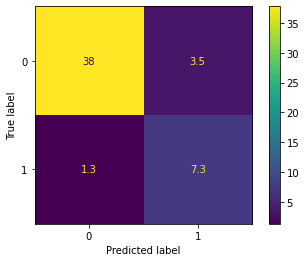

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = cm[0], y=cm[1]))

In [63]:
# First we use sklearn's roc_auc_score() function to find the area under the curve for our initial model. 
# Having calculated this value, we can then plot in on a graph along with our ROC curve.

auc=roc_auc_score(test_norm_df['Attrition'],y_pred )
print(auc)

0.955388013830196


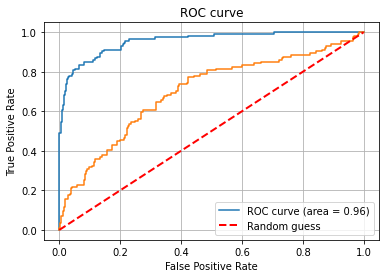

In [64]:
# Use Scikit-learn's ROC Curve Utility to plot ROC curve. For reference, we also include a 'line of determination (y=x)',
# which represents no lift from the model (just random guessing, the worst kind of model performance).
# Our goal is to produce a model that separates from the line of determination and captures as much of the area above the line
# as possible. 
fpr, tpr, thresholds = roc_curve(test['Attrition'],  y_pred)

# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot(og_fpr, og_tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [65]:
len(tpr)

94

In [66]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=thresholds))

In [67]:
thresholds

array([1.99979504e+00, 9.99795041e-01, 9.56162291e-01, 9.53773017e-01,
       9.31978679e-01, 9.27627000e-01, 9.08355138e-01, 8.99204949e-01,
       8.93481807e-01, 8.90886328e-01, 8.71137411e-01, 8.64897312e-01,
       8.45062633e-01, 8.31319748e-01, 8.20840642e-01, 8.16084335e-01,
       8.09048609e-01, 8.08542597e-01, 7.90823918e-01, 7.85233220e-01,
       7.79451637e-01, 7.67150046e-01, 7.64570783e-01, 7.42176390e-01,
       7.31206582e-01, 7.13206960e-01, 7.06191606e-01, 7.02930208e-01,
       6.98007528e-01, 6.83153173e-01, 6.82063919e-01, 6.46352785e-01,
       6.28826329e-01, 5.51887904e-01, 5.33563522e-01, 4.68510106e-01,
       4.63599122e-01, 4.47520039e-01, 4.44755314e-01, 4.38878113e-01,
       4.38501552e-01, 4.33575151e-01, 4.30887420e-01, 4.08162271e-01,
       4.02287486e-01, 3.88076008e-01, 3.86241774e-01, 3.61366049e-01,
       3.60333032e-01, 2.35487920e-01, 2.33902465e-01, 2.16917756e-01,
       2.11852440e-01, 2.09290716e-01, 1.98387469e-01, 1.95901250e-01,
      

In [85]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=thresholds, mode="markers"))
fig.show()

In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=fpr, name = "fpr"))
fig.add_trace(go.Scatter(x=thresholds, y=tpr, name = "tpr"))
fig.add_trace(go.Scatter(x=fpr, y=tpr, name = "AUC"))
fig.add_trace(go.Scatter(x=[1, 0], y=[0, 1], name = "AUC"))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name = "AUC"))


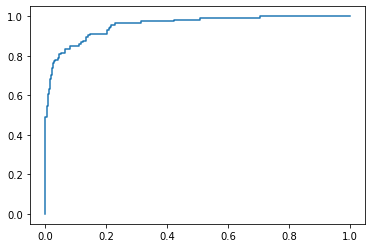

In [69]:
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)

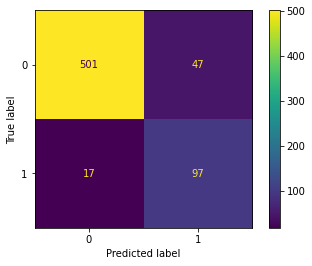

In [70]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_og)
disp.plot()
plt.show()

In [80]:
sum(sum(cm_og))*tpr_best

563.280701754386

In [72]:
cm_og[0][1]

47

In [73]:
tpr_best=cm_og[1][1]/(cm_og[1][0]+cm_og[1][1])
fpr_best=cm_og[0][1]/(cm_og[0][0]+cm_og[0][1])

In [77]:
tpr_best

0.8508771929824561

In [81]:
fpr_best

0.08576642335766424

In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, name = "AUC", line=dict(color='rgb(0, 151, 167)', width=1.5)))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], line=dict(color='rgb(167, 16, 0)'), name="Random Guess"))
fig.add_trace(go.Scatter(x=[fpr_best], y=[tpr_best],mode="markers", marker_symbol="circle-dot", name="Our Balanced Model",
        marker=dict(
            color='rgba(135, 206, 250, .3)',
            size=40,
            line=dict(
                color='black',
                width=3
            )
        ),))

fig.add_trace(go.Scatter(x=[0], y=[1],mode="markers", marker_symbol="x-thin", name="Perfect Model",
        marker=dict(
            size=10,
            color='black',
            line=dict(
                color='black',
                width=3
            )
        ),))
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
    width=300,  # Set width of the plot
    height=300  # Set height of the plot
)
#Set X-axis title
fig.update_xaxes(title_text="False Positive Rate")
#Set Y-axis title
fig.update_yaxes(title_text="True Positive Rate")

#Set x and y axis to labels to black
fig.update_xaxes(tickfont=dict(family='Arial', color='black', size=12))
fig.update_yaxes(tickfont=dict(family='Arial', color='black', size=12))

fig.update_layout(legend=dict(font=dict(family='Arial', color='black', size=12)))
#Change legend position
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.35,
    xanchor="left",
    x=0.4
))
#Remove Margin
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

fig.show()


In [76]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train["DistanceFromHome"]))
fig.show()